In [181]:
# imports
import matplotlib.pyplot as plt
import rebound
import numpy as np
#plt.style.use('paper')
from celmech.lie_transformations import FirstOrderGeneratingFunction
from celmech import Poincare
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech.disturbing_function import get_fg_coefficients
from celmech.miscellaneous import sk

In [182]:
# constants
mu=3e-12 *125       # m_1/m_star
j, k = 100, 1       # j:j-k MMR (so this is a 20:19 resonance)
pomega = np.pi/2    # pericenter of outer test particle
phi = -np.pi/3     # Angle of conjunction relative to pericenter (resonant angle)

n = 2*np.pi         # mean motion of inner planet (is just 2*pi so period = 1)
n20 = n*(j-k)/j     # initial mean motion of outer particle (19/20*n) (at resonance value)
                    # completes 19 orbits in the same time the inner planet completes 20 orbits
dares = (j/(j-k))**(2/3)-1 # delta a_res-- distance between test particle and planet at resonance
deltan = 0          # delta n: deviation of mean motion from resonance
                    # this small value is added to n20 bc the planet isn't *exactly* at resonance

ec = 2*k/3/j        # crossing eccentricity, factor to normalize e
etilde = 0.1        # eccentricity ratio to crossing value (e/e_c)

e = etilde*ec       # eccentricity
deltat = 2/3/n20    # time to move delta a in y at a rate delta v, 
                    #   where v = a*delta_n and delta_n = n2-n1
                    #   Goal: to find how far back to integrate

tconj=j/k           # time between conjunctions-- big if delta n is small
# ps[1].P = 1

epsilon = (1/3*mu)**(1/3) # small mass parameter

# coefficient values from Namouni paper
W1 = 3.359350011
W2 = 2.678665722
W3 = 2.639498803
W4 = 2.8559
W5 = 3.2594
W6 = 3.8508
W7 = 4.6616
W8 = 5.7459

In [183]:
# setup

def setup(t0=-deltat, theta=None, to_print=True, phi = phi, etilde = etilde): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu, P=1, 
            l=pomega+phi+n*t0) # phi = l - pomega, so l = pomega+phi
    ps = sim.particles
    if theta is None:
        theta = pomega+phi+n20*t0
    sim.add(P=2*np.pi/(n20+deltan), e=etilde*ec, pomega=pomega, l=theta)
    sim.t = t0
    
#     if to_print:
#         print('Hill radius separation:', (sim.particles[2].a-sim.particles[1].a)/(mu/3)**(1/3)) # , sim.particles[1].l
    return sim

def calculate_phi_correction(phi_0, etilde, iterations, Nout, tmin, tmax):
    iteration = 0
    correction = 0
    correction_iter = 0
    while iteration <= iterations:
        phi = phi_0 - correction
        sim = setup(t0 = tmin, phi = phi, etilde = etilde)
        ps = sim.particles
        dl, pomega2, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(tmin, tmax, Nout)
        for i, time in enumerate(times):
            sim.integrate(time)
            if ps[2].l - ps[1].l > np.pi:
                dl[i] = ps[2].l - ps[1].l - 2*np.pi
            elif ps[2].l - ps[1].l < -np.pi:
                dl[i] = ps[2].l - ps[1].l + 2*np.pi
            else:
                dl[i] = ps[2].l - ps[1].l
            pomega2[i] = ps[2].pomega #pomega of test particle
            phi_arr[i] = ps[2].l - ps[2].pomega
        conj_idx = np.argmin(np.abs(dl))
        #print (phi)
        correction = phi_arr[conj_idx] - phi
        #print (correction)
        correction_iter = phi_arr[conj_idx] - phi_0
        #print (correction_iter)
        iteration += 1
    return correction, correction_iter # (correction angle and the deviation from the actual phi)
        
        
def calc_Delta_a(da_list, conj_idx):
    '''returns change in da from before to after conjunction given list of a values 
       throughout conj'''
    da0_max_idx = np.argmax(da_list[:conj_idx]) # max value of a before conjunction, 
                                              # corresponds to peak just before conj

    daf_max_idx = (np.argmax(da_list[conj_idx:]) # max value of a after conjunction 
                   + conj_idx)                    

    da0 = np.mean(da_list[:da0_max_idx])
    daf = np.mean(da_list[daf_max_idx:])

    Delta_a = daf-da0

    return Delta_a, da0, daf

In [185]:
calculate_phi_correction(2*np.pi/3, 0.1, 2, 100000, -0.805*tconj , 0.815*tconj )

(0.019960942903502144, 1.1957732835021773e-06)

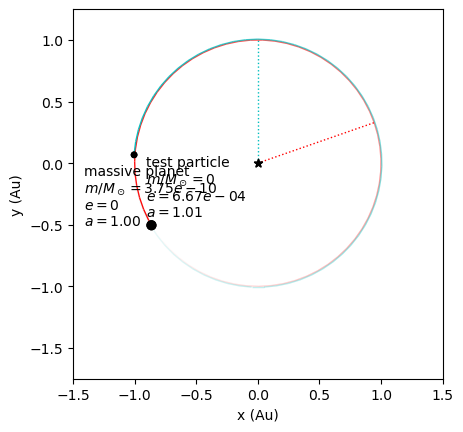

In [195]:
# Run an encounter

# set up integration where conjunction is at time = 0
tmin = -0.905*tconj 
tmax = 0.915*tconj 
Nout = 100000
cor = calculate_phi_correction(phi, etilde, 2, Nout, tmin, tmax)[0]
sim = setup(t0=tmin, phi = phi - cor)
ps = sim.particles
da0 = ps[2].a-ps[1].a # initial diff in a
dr0 = ps[2].a*ps[2].e
conj_idx = 0 # initializing 

Rh = ps[1].a*epsilon # hill radius

# plot initial position of planets
fig, ax = plt.subplots()
ax.set_aspect("equal") 
op = rebound.OrbitPlot(sim, fig=fig, ax=ax, color=True, periastron=True, 
                       xlim=[-1.5,1.5], ylim=[-1.75,1.25])
op.particles.set_sizes([40,15])
ax.annotate('massive planet \n$m/M_\odot={:.2e}$ \n$e=0$ \n$a={:.2f}$'
            .format(mu, ps[1].a), (ps[1].x -.55,ps[1].y))
ax.annotate('test particle \n$m/M_\odot=0$ \n$e={:.2e}$ \n$a={:.2f}$'
            .format(e, ps[2].a), (ps[2].x + ps[1].a/10,ps[2].y-.5))
ax.set(xlabel='x (Au)', ylabel='y (Au)')
fig.savefig('initial_orbitplot.pdf')


In [196]:
# integrate 


dr, da, dl, dtheta, pomega2, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(tmin, tmax, Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    dr[i] = ((ps[2].x - ps[1].x)**2+(ps[2].y - ps[1].y)**2)**0.5
    da[i] = ps[2].a - ps[1].a
    if ps[2].l - ps[1].l > np.pi:
        dl[i] = ps[2].l - ps[1].l - 2*np.pi
    elif ps[2].l - ps[1].l < -np.pi:
        dl[i] = ps[2].l - ps[1].l + 2*np.pi
    else:
        dl[i] = ps[2].l - ps[1].l
        
    if ps[2].theta - ps[1].theta > np.pi:
        dtheta[i] = ps[2].theta - ps[1].theta - 2*np.pi
    elif ps[2].theta - ps[1].theta < -np.pi:
        dtheta[i] = ps[2].theta - ps[1].theta + 2*np.pi
    else:
        dtheta[i] = ps[2].theta - ps[1].theta
    dtheta[i] = dtheta[i] - dl[i]
    pomega2[i] = ps[2].pomega #pomega of test particle
    phi_arr[i] = ps[2].l - ps[2].pomega

    ## OrbitPlot at conjunction if time is set to conj
    # fig, ax = plt.subplots()
    # ax.set_aspect("equal") 
    # op = rebound.OrbitPlot(sim, particles=[1], fig=fig, ax=ax, color='red', xlim=[-1.5,1.5], ylim=[-1.5,1.5])
    # op = rebound.OrbitPlot(sim, particles=[2], fig=fig, ax=ax, color='blue', xlim=[-1.5,1.5], ylim=[-1.5,1.5])
    # op.particles.set_sizes([10,50])
    # ax.set(xlabel='x (Au)', ylabel='y (Au)', title='Conjunction')
    # fig.tight_layout()
    # fig.savefig('op_true_conj_presentation.png', dpi=300)

daf = ps[2].a-ps[1].a # final diff in a
drf = ps[2].a*ps[2].e

# find the index of conjunciton via min of da (they are closest exactly at conj)
conj_idx = np.argmin(dr)
conj_idx_2 = np.argmin(da)
conj_idx_3 = int(-Nout*tmin/(tmax-tmin))
conj_idx_4 = np.argmin(np.abs(dl)) #this one gives the best matching result
#conj_idx_5 = np.argmin(np.abs(dtheta))
_, da0_plot, daf_plot = calc_Delta_a(da, conj_idx)

print(phi_arr[conj_idx] + np.pi/3)
print(phi_arr[conj_idx_2] + np.pi/3)
print(phi_arr[conj_idx_3] + np.pi/3)
print(phi_arr[conj_idx_4] + np.pi/3)
#print(phi_arr[conj_idx_5] - 2*np.pi/3)

-0.07897903958306252
-0.12404316465563459
-1.908866509303664e-08
-1.908866509303664e-08


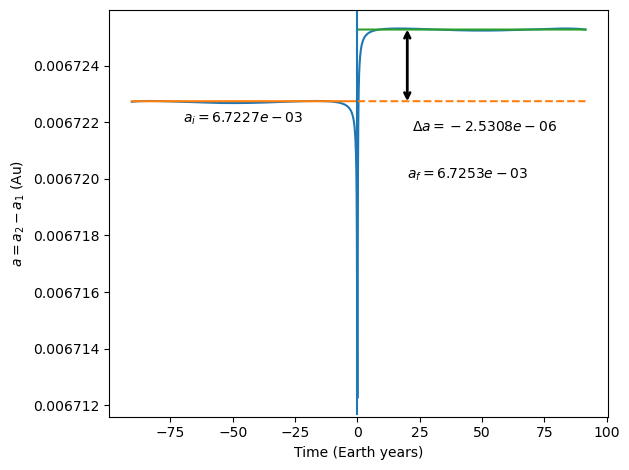

In [199]:
# plot da throughout encounter

fig, ax = plt.subplots()
ax.plot(times, da)
t_before_conj = times[:conj_idx_4]
t_after_conj = times[conj_idx_4:]
ax.plot(t_before_conj, np.ones_like(t_before_conj)*da0_plot, label='pre-conjunction')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*da0_plot, c='C1', linestyle='--')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*daf_plot, label='post-conjunction')
ax.axvline(times[conj_idx_4], da[conj_idx_4]) # conjunction location
ax.annotate('$a_i={:.4e}$'.format(da0_plot), (-70, .006722))
ax.annotate('$a_f={:.4e}$'.format(daf_plot), (20, .006720))
ax.annotate("", (20, da0_plot), (20, daf_plot), arrowprops={'arrowstyle':'<->','shrinkA':0, 'shrinkB':0,'linewidth':2, 'color':'black'})
ax.annotate('$\Delta a={:.4e}$'.format(da0_plot-daf_plot), (22, .0067217))
ax.set(xlabel='Time (Earth years)', ylabel='$a = a_2 - a_1$ (Au)') #title='Evolution of Relative Semimajor Axis during Conjunction')
#ax.legend()
fig.tight_layout()
fig.savefig('delta_a.pdf')


In [208]:
Nout = 100000 # num time steps in integration
N = 25 #
etilde_list = np.linspace(0.001, .5, N)
a_kicks, paper_1, paper_2, paper_3, paper_4, paper_5, paper_6, paper_7, paper_8 = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
for idx, etilde in enumerate(etilde_list):
    #setup
    e = etilde*ec
    cor = calculate_phi_correction(phi, etilde, 1, Nout, tmin, tmax)[0]
    sim = setup(t0=tmin, to_print=False, phi = phi - cor, etilde = etilde)
    ps = sim.particles
    da0 = ps[2].a-ps[1].a

    # integration
    x, y, da, dl, pomega2, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(tmin, tmax, Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        da[i] = ps[2].a - ps[1].a
        dl[i] = ps[2].l - ps[1].l
        pomega2[i] = ps[2].pomega #pomega of test particle
        x[i] = ps[2].d - ps[1].d
        phi_arr[i] = ps[2].l - ps[2].pomega
    
    # conjunction index, angle at conjunction
    conj_idx = np.argmin(np.abs(dl))
    theta = phi_arr[conj_idx] # angle at conjunction
    print (theta - 2*np.pi/3)
    #theta = 2*np.pi/3
    
    
    # n-body solution
    Delta_a, da0, daf = calc_Delta_a(da, conj_idx)
    
    #delta_a = daf - da0
    a_kicks[idx] = Delta_a / ps[1].a

    # Namouni solution
    paper_1[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1) # 1st order approx
    paper_2[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2) # 2rd order approx
    paper_3[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta)) # 3rd order approx
    paper_4[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta)) # 4th order approx
    paper_5[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta)
                                        + 5*W5*etilde**5*np.sin(5*theta))
    paper_6[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta) 
                                        + 5*W5*etilde**5*np.sin(5*theta) + 6*W6*etilde**6*np.sin(6*theta))
    paper_7[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta) 
                                        + 5*W5*etilde**5*np.sin(5*theta) + 6*W6*etilde**6*np.sin(6*theta) + 7*W7*etilde**7*np.sin(7*theta))
    paper_8[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta) 
                                        + 5*W5*etilde**5*np.sin(5*theta) + 6*W6*etilde**6*np.sin(6*theta) + 7*W7*etilde**7*np.sin(7*theta) + 8*W8*etilde**8*np.sin(8*theta))

-3.28369228919884
-3.1416915479109697
-3.1416076625450104
-3.1415974729283755
-3.1415947391572296
-3.141593694380391
-3.1415932053449076
-3.1415929448785755
-3.1415927939290844
-3.141592701830062
-3.1415926443711486
-3.141592608850295
-3.1415925880256257
-3.1415925774219287
-3.1415925740487127
-3.141592575755858
-3.1415925809150425
-3.141592588246988
-3.141592596740861
-3.141592605612029
-3.1415926142704715
-3.1415926222998247
-3.1415926294378096
-3.141592635545754
-3.1415926405914782


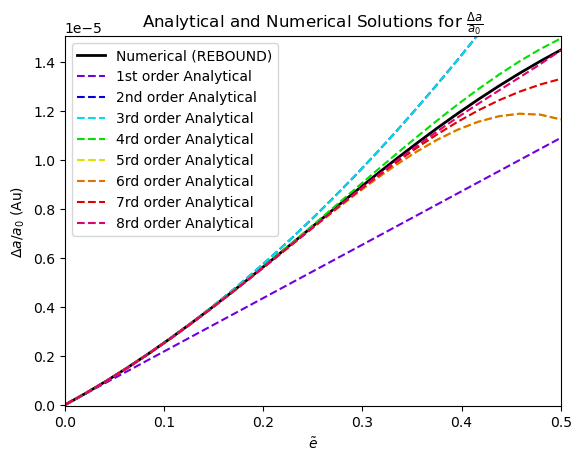

In [209]:
# plot comparison of kicks to a (n-body vs Namouni)

fig, ax = plt.subplots()
ax.plot(etilde_list, a_kicks, 'k-', linewidth=2, label='Numerical (REBOUND)')
ax.plot(etilde_list, paper_1, '--', label='1st order Analytical', c='#7000E0')
ax.plot(etilde_list, paper_2, '--', label='2nd order Analytical', c='#0000E0')
ax.plot(etilde_list, paper_3, '--', label='3rd order Analytical', c='#00E0E0')
ax.plot(etilde_list, paper_4, '--', label='4rd order Analytical', c='#00E000')
ax.plot(etilde_list, paper_5, '--', label='5rd order Analytical', c='#E0E000')
ax.plot(etilde_list, paper_6, '--', label='6rd order Analytical', c='#E07000')
ax.plot(etilde_list, paper_7, '--', label='7rd order Analytical', c='#E00000')
ax.plot(etilde_list, paper_8, '--', label='8rd order Analytical', c='#E00070')
ax.set_xlim(0, 0.5)
ax.set_ylim(-0.05*1e-6, 15.05*1e-6)
ax.set(xlabel="$\\tilde{e}$", ylabel='$\Delta a$/$a_0$ (Au)', title='Analytical and Numerical Solutions for $\\frac{\Delta a}{a_0}$')

ax.legend()
#fig.savefig('comp_plot.pdf') # pdf
fig.savefig('comp_plot.png', dpi=300) # png

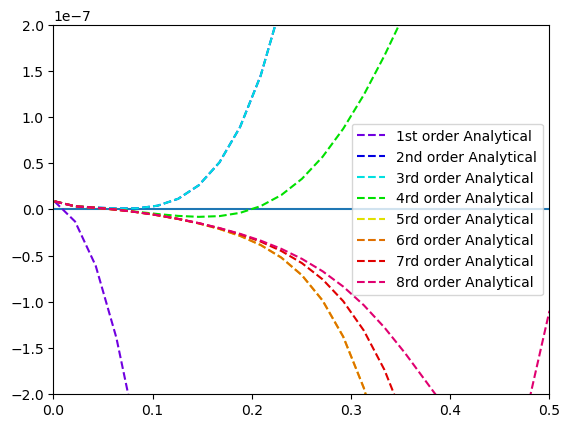

In [207]:
# plot the difference
paper_1_d,paper_2_d,paper_3_d,paper_4_d,paper_5_d,paper_6_d,paper_7_d,paper_8_d = np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N)
for i in range(N):
    paper_1_d[i] = (paper_1[i] - a_kicks[i])#/a_kicks[i]
    paper_2_d[i] = (paper_2[i] - a_kicks[i])#/a_kicks[i]
    paper_3_d[i] = (paper_3[i] - a_kicks[i])#/a_kicks[i]
    paper_4_d[i] = (paper_4[i] - a_kicks[i])#/a_kicks[i]
    paper_5_d[i] = (paper_5[i] - a_kicks[i])#/a_kicks[i]
    paper_6_d[i] = (paper_6[i] - a_kicks[i])#/a_kicks[i]
    paper_7_d[i] = (paper_7[i] - a_kicks[i])#/a_kicks[i]
    paper_8_d[i] = (paper_8[i] - a_kicks[i])#/a_kicks[i]
fig, ax = plt.subplots()

ax.axhline(0, 0) # conjunction location
ax.set_xlim(0, 0.5)
ax.set_ylim(-0.2e-6, 0.2e-6)
ax.plot(etilde_list, paper_1_d, '--', label='1st order Analytical', c='#7000E0')
ax.plot(etilde_list, paper_2_d, '--', label='2nd order Analytical', c='#0000E0')
ax.plot(etilde_list, paper_3_d, '--', label='3rd order Analytical', c='#00E0E0')
ax.plot(etilde_list, paper_4_d, '--', label='4rd order Analytical', c='#00E000')
ax.plot(etilde_list, paper_5_d, '--', label='5rd order Analytical', c='#E0E000')
ax.plot(etilde_list, paper_6_d, '--', label='6rd order Analytical', c='#E07000')
ax.plot(etilde_list, paper_7_d, '--', label='7rd order Analytical', c='#E00000')
ax.plot(etilde_list, paper_8_d, '--', label='8rd order Analytical', c='#E00070')
ax.legend()

In [ ]:
#try to generalize to 2-eccentric planets case
#test out the case where ecom = 0 ((m1e1 + m2e2)/(m1+m2))